# ⚡ IND320 Project Part 3 – Open-Meteo API and Elhub Data Analysis


## 🔗 Links
**GitHub Repository:** https://github.com/LarsSolbakken/Ind320-Lars

**Streamlit App:** https://ind320-lars-goeqtbwxguxey2shc4qfus.streamlit.app/


## Imports


In [ ]:
# --- Core libraries ---
import numpy as np
import pandas as pd
import requests

# --- Visualization ---
import matplotlib.pyplot as plt

# --- Signal processing and time-series analysis ---
from scipy.fftpack import dct, idct
from scipy.signal import spectrogram
from statsmodels.tsa.seasonal import STL

# --- Machine learning (for anomaly detection) ---
from sklearn.neighbors import LocalOutlierFactor


## 📘 1. Introduction
This notebook is part of the IND320 project and builds on previous parts.  
It combines **meteorological data** (from the Open-Meteo ERA5 reanalysis API) with **electricity production data** (from Elhub).  

The main goals are to:
- Retrieve, clean, and analyze time-series data.
- Apply statistical and signal-processing techniques for **outlier** and **anomaly detection**.
- Visualize patterns through **STL decomposition** and **spectrograms**.


## 🌍 2. City and Price Area Mapping
The five Norwegian electricity price areas are represented by one city each.  
This table shows their names, price area codes, and geographical coordinates (latitude, longitude).


In [ ]:


# --- Step 1: Define Norwegian electricity price areas and representative cities ---
# Each price area (NO1–NO5) is linked to one major city.
# Latitude and longitude coordinates are used later for API calls.
data = {
    "price_area": ["NO1", "NO2", "NO3", "NO4", "NO5"],
    "city": ["Oslo", "Kristiansand", "Trondheim", "Tromsø", "Bergen"],
    "latitude": [59.91, 58.15, 63.43, 69.65, 60.39],
    "longitude": [10.75, 8.00, 10.40, 18.96, 5.32]
}

# Create a DataFrame for easier lookup and display
cities_df = pd.DataFrame(data)
print(cities_df)


  price_area          city  latitude  longitude
0        NO1          Oslo     59.91      10.75
1        NO2  Kristiansand     58.15       8.00
2        NO3     Trondheim     63.43      10.40
3        NO4        Tromsø     69.65      18.96
4        NO5        Bergen     60.39       5.32


## ☁️ 3. Downloading Meteorological Data (Open-Meteo API)
The `download_weather()` function connects to the **Open-Meteo ERA5 API** to download hourly temperature and precipitation data.  
ERA5 is a reanalysis model combining historical weather observations with physical modeling to estimate past weather conditions.


In [ ]:


def download_weather(lon, lat, year):
    """
    Download historical weather data (ERA5 reanalysis) for a given location and year.
    
    Parameters:
        lon (float): Longitude of the location
        lat (float): Latitude of the location
        year (int): Year (e.g. 2019)
    
    Returns:
        pd.DataFrame: Weather time series with hourly values for temperature and precipitation
    """
    # --- Step 1: Define API endpoint ---
    # ERA5 is a reanalysis dataset combining observations and models to reconstruct past weather.
    url = "https://archive-api.open-meteo.com/v1/era5"
    
    # --- Step 2: Define request parameters ---
    # Selects one year of hourly data for temperature and precipitation
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": f"{year}-01-01",
        "end_date": f"{year}-12-31",
        "hourly": ["temperature_2m", "precipitation"],
        "timezone": "Europe/Oslo"
    }
    
    # --- Step 3: Send the request and check for errors ---
    response = requests.get(url, params=params)
    response.raise_for_status()  # Stop if API call fails
    
    # Parse response to JSON
    data = response.json()
    
    # --- Step 4: Convert JSON to DataFrame ---
    df = pd.DataFrame({
        "time": data["hourly"]["time"],
        "temperature_2m": data["hourly"]["temperature_2m"],
        "precipitation": data["hourly"]["precipitation"]
    })
    
    # --- Step 5: Clean up and prepare for time-series analysis ---
    # Convert time strings to datetime objects
    df["time"] = pd.to_datetime(df["time"])
    # Set 'time' as index so it’s ready for resampling and plotting
    df = df.set_index("time").sort_index()
    return df




### Example: Download weather data for Bergen (2019)
This example applies the function to Bergen to test the download and structure of the returned dataset.


In [ ]:
# Example: Download weather data for Bergen (price area NO5)
bergen_2019 = download_weather(5.32, 60.39, 2019)
print(bergen_2019.head())

,temperature_2m,precipitation
time,,
2019-01-01 00:00:00,5.7,0.7
2019-01-01 01:00:00,5.8,0.2
2019-01-01 02:00:00,6.1,0.7
2019-01-01 03:00:00,6.3,0.5
2019-01-01 04:00:00,5.8,1.1


## 🌡️ 4. Outlier Detection (Temperature – SPC + DCT)
Temperature outliers are identified by combining:
- A **high-pass filter** using the **Discrete Cosine Transform (DCT)** to remove seasonal effects.
- **Statistical Process Control (SPC)** boundaries (±σ) to mark unusual deviations.

Outliers are plotted in red, and the control limits are shown as dashed lines.


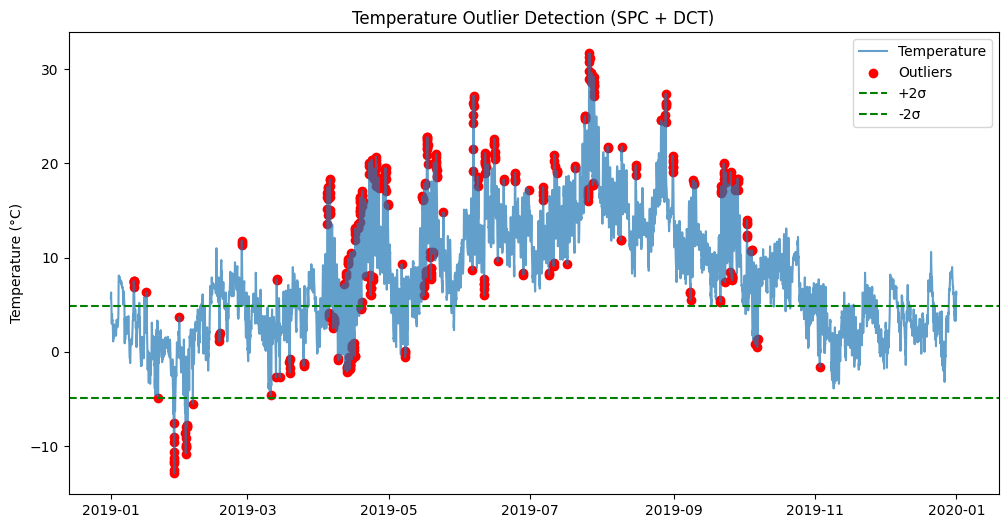

time
2019-01-10 20:00:00    7.5
2019-01-10 21:00:00    7.5
2019-01-10 22:00:00    7.5
2019-01-10 23:00:00    7.4
2019-01-11 00:00:00    7.3
Name: temperature_2m, dtype: float64


In [ ]:


def detect_outliers(temp_series, cutoff=100, std_mult=2):
    """
    Detect temperature outliers using DCT high-pass filter + SPC.

    Parameters:
        temp_series (pd.Series): Time-indexed temperature series
        cutoff (int): Frequency cutoff for DCT filtering (lower = smoother seasonal component removed)
        std_mult (float): Number of std deviations for SPC boundaries

    Returns:
        fig, ax, outliers_df
    """
    # --- Step 1: Apply DCT (Discrete Cosine Transform) ---
    # DCT decomposes the signal into frequency components.
    # We use it here to isolate high-frequency (short-term) variations.
    values = temp_series.values
    dct_coeff = dct(values, norm="ortho")

    # --- Step 2: Remove low frequencies to remove seasonal trends ---
    # Keeping only high frequencies gives seasonally adjusted temperature variations (SATV)
    dct_coeff[:cutoff] = 0
    satv = idct(dct_coeff, norm="ortho")

    # --- Step 3: Compute SPC (Statistical Process Control) boundaries ---
    # Outliers are defined as values exceeding mean ± std_mult * std
    mean = np.mean(satv)
    std = np.std(satv)
    upper = mean + std_mult * std
    lower = mean - std_mult * std

    # Create boolean mask for outliers
    mask_outliers = (satv > upper) | (satv < lower)
    outliers_df = temp_series[mask_outliers]

    # --- Step 4: Plot original data and outliers ---
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(temp_series.index, temp_series.values, label="Temperature", alpha=0.7)
    ax.scatter(outliers_df.index, outliers_df.values, color="red", label="Outliers")
    ax.axhline(upper, color="green", linestyle="--", label=f"+{std_mult}σ")
    ax.axhline(lower, color="green", linestyle="--", label=f"-{std_mult}σ")
    ax.set_title("Temperature Outlier Detection (SPC + DCT)")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()

    return fig, ax, outliers_df




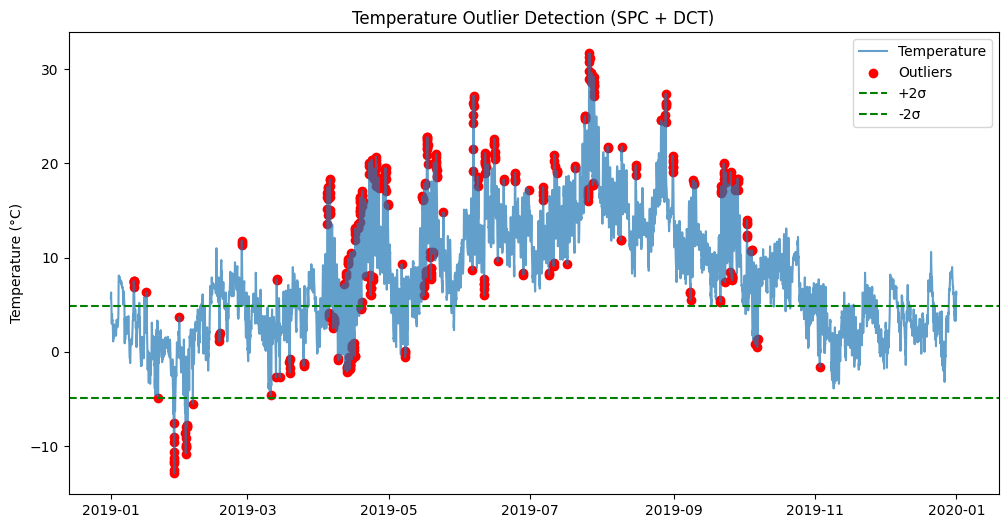

time
2019-01-10 20:00:00    7.5
2019-01-10 21:00:00    7.5
2019-01-10 22:00:00    7.5
2019-01-10 23:00:00    7.4
2019-01-11 00:00:00    7.3
Name: temperature_2m, dtype: float64


In [15]:


# Detect temperature outliers
fig, ax, outliers_temp = detect_outliers(bergen_2019["temperature_2m"], cutoff=100, std_mult=2)
plt.show()

# Display outlier summary
print(outliers_temp.head())

## 🌧️ 5. Anomaly Detection (Precipitation – LOF)
Precipitation anomalies are detected using the **Local Outlier Factor (LOF)** algorithm,  
which identifies points that differ significantly from their local neighborhood density.  
Anomalies are highlighted as red points in the plot.


/opt/anaconda3/envs/D2D_env/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


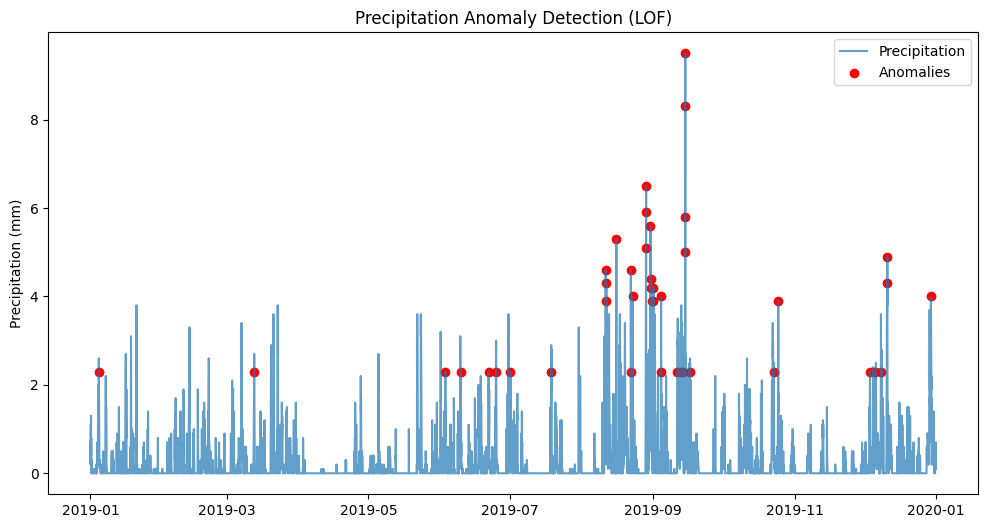

time
2019-01-04 16:00:00    2.3
2019-03-12 16:00:00    2.3
2019-06-03 05:00:00    2.3
2019-06-09 21:00:00    2.3
2019-06-21 21:00:00    2.3
Name: precipitation, dtype: float64


In [ ]:


def detect_anomalies(series, proportion=0.01):
    """
    Detect precipitation anomalies using Local Outlier Factor (LOF).

    Parameters:
        series (pd.Series): Time-indexed precipitation series
        proportion (float): Expected proportion of anomalies

    Returns:
        fig, ax, anomalies_df
    """
    # --- Step 1: Prepare data for LOF (must be 2D array) ---
    values = series.values.reshape(-1, 1)

    # --- Step 2: Fit LOF model ---
    # LOF compares local density of each point to its neighbors.
    # Points with much lower density are marked as anomalies.
    lof = LocalOutlierFactor(n_neighbors=20, contamination=proportion)
    preds = lof.fit_predict(values)  # -1 = anomaly, 1 = normal

    # --- Step 3: Extract anomalies and plot ---
    mask_anomalies = preds == -1
    anomalies_df = series[mask_anomalies]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(series.index, series.values, label="Precipitation", alpha=0.7)
    ax.scatter(anomalies_df.index, anomalies_df.values, color="red", label="Anomalies")
    ax.set_title("Precipitation Anomaly Detection (LOF)")
    ax.set_ylabel("Precipitation (mm)")
    ax.legend()

    return fig, ax, anomalies_df




/opt/anaconda3/envs/D2D_env/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


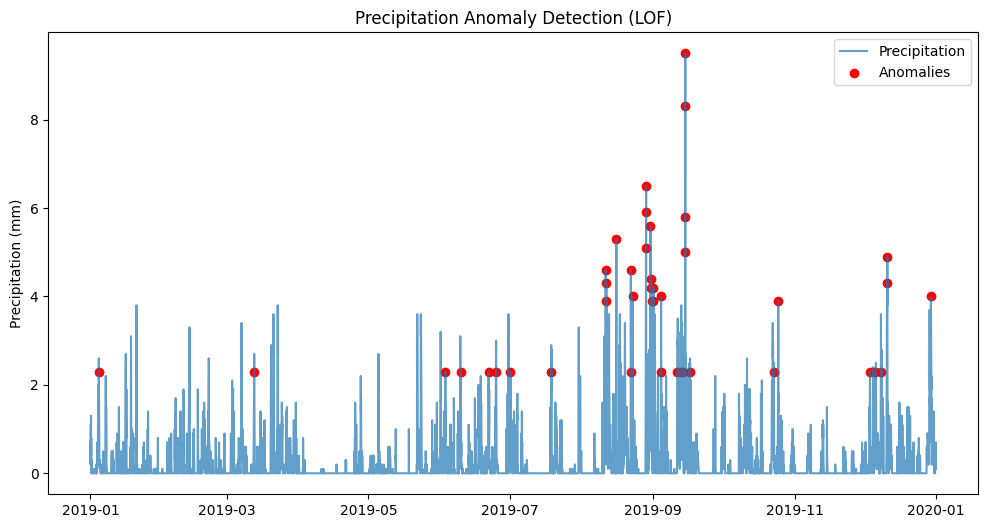

time
2019-01-04 16:00:00    2.3
2019-03-12 16:00:00    2.3
2019-06-03 05:00:00    2.3
2019-06-09 21:00:00    2.3
2019-06-21 21:00:00    2.3
Name: precipitation, dtype: float64


In [17]:
# Detect precipitation anomalies
fig, ax, anomalies_precip = detect_anomalies(bergen_2019["precipitation"], proportion=0.005)
plt.show()
print(anomalies_precip.head())


## ⚡ 6. STL Decomposition (Elhub Data)
The **STL decomposition** (Seasonal-Trend decomposition using LOESS) splits the electricity production time series  
into three components:
- **Trend** (long-term evolution)
- **Seasonal** (periodic fluctuations)
- **Residual** (random noise)

This helps visualize underlying patterns in the Elhub production data.


In [ ]:


def stl_decompose(data, area, group, period=24, seasonal=13, trend=91, robust=True):
    """
    Perform STL decomposition on Elhub production data.

    Parameters:
        data (pd.DataFrame): Must contain columns [startTime, priceArea, productionGroup, quantityKWh]
        area (str): Price area code, e.g. 'NO1'
        group (str): Production group, e.g. 'hydro'
        period (int): Seasonal period length (e.g. 24 for daily seasonality in hourly data)
        seasonal (int): Seasonal smoother
        trend (int): Trend smoother
        robust (bool): Robust to outliers

    Returns:
        fig: Matplotlib figure with decomposition plots
        res: STL result object (with trend, seasonal, resid)
    """
    # --- Step 1: Filter relevant subset ---
    df = data[(data["priceArea"] == area) & (data["productionGroup"] == group)].copy()

    # --- Step 2: Convert and index time ---
    df["startTime"] = pd.to_datetime(df["startTime"])
    df = df.set_index("startTime").sort_index()

    # --- Step 3: Apply STL decomposition ---
    stl = STL(df["quantityKWh"], period=period, seasonal=seasonal, trend=trend, robust=robust)
    res = stl.fit()

    # --- Step 4: Plot components ---
    fig = res.plot()
    fig.set_size_inches(12, 8)
    plt.suptitle(f"STL Decomposition – {group} in {area}", fontsize=14)

    return fig, res


## 🔊 7. Spectrogram (Elhub Data)
A **spectrogram** shows how the frequency content of electricity production varies over time.  
It is based on the **short-time Fourier transform** and can highlight repeating patterns and irregular events.


In [ ]:


def make_spectrogram(data, area, group, window_length=168, overlap=84):
    """
    Create a spectrogram for Elhub production data.

    Parameters:
        data (pd.DataFrame): Must contain columns [startTime, priceArea, productionGroup, quantityKWh]
        area (str): Price area code, e.g. 'NO1'
        group (str): Production group, e.g. 'hydro'
        window_length (int): Window length in samples (e.g. 168 for 1 week of hourly data)
        overlap (int): Number of samples to overlap between windows (e.g. 84 for 50%)
    
    Returns:
        fig, ax: Matplotlib figure and axis with the spectrogram plot
    """
    # --- Step 1: Filter data for chosen area and production type ---
    df = data[(data["priceArea"] == area) & (data["productionGroup"] == group)].copy()
    df["startTime"] = pd.to_datetime(df["startTime"])
    df = df.set_index("startTime").sort_index()

    # --- Step 2: Prepare signal and sampling parameters ---
    signal = df["quantityKWh"].values
    fs = 1  # 1 sample per hour

    # --- Step 3: Compute spectrogram (time-frequency representation) ---
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=window_length, noverlap=overlap)

    # --- Step 4: Plot spectrogram ---
    fig, ax = plt.subplots(figsize=(12, 6))
    pcm = ax.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-12), shading='auto', cmap='viridis')
    fig.colorbar(pcm, ax=ax, label="Power (dB)")

    ax.set_title(f"Spectrogram – {group} in {area}")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Frequency (cycles/hour)")

    return fig, ax


## 🤖 8. AI Usage
ChatGPT (GPT-5, OpenAI) was used as a learning and support tool during this project.  
It helped with:
- Understanding the Open-Meteo API documentation and function structure.  
- Debugging and improving Python code for caching, indexing, and plotting.  
- Clarifying the theory behind STL, DCT filtering, and LOF anomaly detection.  

All code and analyses were verified, modified, and tested by me to ensure full understanding.  
The AI was used for guidance and not for automatic code generation without review.


## 📓 9. Project Log
This project extended earlier IND320 work by integrating meteorological data from the **Open-Meteo API**  
and production data from **Elhub** into one analytical workflow and Streamlit dashboard.

The first step was to define five Norwegian cities (Oslo, Kristiansand, Trondheim, Tromsø, Bergen)  
with their latitude, longitude, and electricity price areas.  
Using this information, I built a custom API function that downloads hourly temperature  
and precipitation data from the ERA5 reanalysis model.  

Replacing the previous CSV file with live API data was the biggest conceptual improvement,  
as it demonstrated dynamic data integration.  

Next, I implemented analytical methods for time-series insights:
- For temperature, I applied **Discrete Cosine Transform** filtering combined with **SPC boundaries** to find outliers.
- For precipitation, I implemented the **Local Outlier Factor (LOF)** algorithm to identify anomalies.
- For production data, I used **STL decomposition** to separate seasonal, trend, and residual components,
  and **spectrograms** to visualize frequency-based variations.

Finally, all results were integrated into a multi-page **Streamlit app**,  
with tabs for STL/Spectrogram and Outlier/Anomaly analysis.  
Session state was used to share selections between pages,  
and the app now fetches live API weather data and MongoDB-stored Elhub data.

Throughout this project, I learned to combine APIs, databases, and statistical analysis in one coherent pipeline.  
It strengthened my understanding of time-series data, data cleaning, and visualization —  
and gave hands-on experience in turning data-science theory into a real interactive product.
